# ETL
    1. Import data from openbb
    2. Compute daily returns based on Adjusted close price

In [1]:
from openbb_terminal.sdk import openbb
import riskfolio as rp

Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

In [2]:
new_highs = openbb.stocks.screener.screener_data('new_low')

In [3]:
targeted_new_highs = new_highs[(new_highs.Price > 15) &
                    (new_highs.Country == 'USA')]
tickers = targeted_new_highs.Ticker.to_list()

In [4]:
historic_ticker_data = openbb.economy.index(tickers, start_date='2019-01-01', end_date='2023-10-31')

In [5]:
returns = historic_ticker_data.pct_change()[1:]

In [6]:
returns.dropna(how="any", axis=1, inplace=True)

## Risk Analysis

In [7]:
portfolio = rp.Portfolio(returns=returns)

In [8]:
# Define params for risk parity optimizer
portfolio.lowerret = 0.0008
portfolio.assets_stats(method_mu="hist", method_cov="hist", d=0.94)
w_rp = portfolio.rp_optimization(model="Classic", rm="MV", rf=0.05, hist=True)

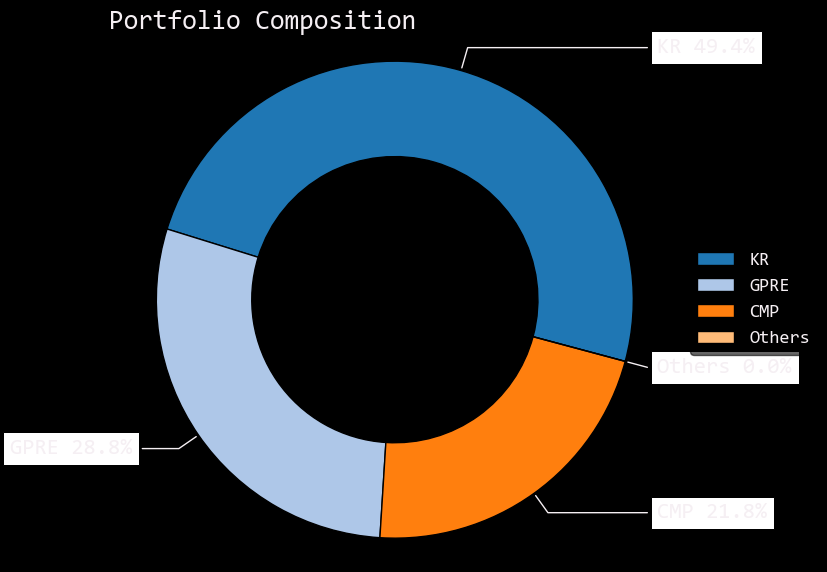

In [9]:
pie = rp.plot_pie(
    w=w_rp
)

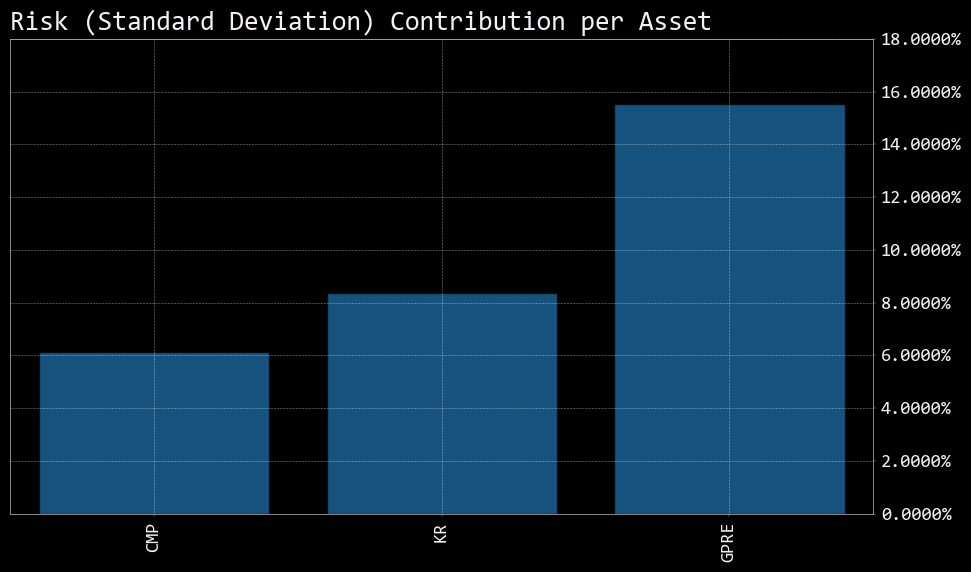

In [10]:
ax = rp.plot_risk_con(
    w=w_rp,
    cov= portfolio.cov,
    returns= portfolio.returns,
    rm="MV",
    rf=0.05
)

In [ ]:
portfolio_value = 100_000

In [ ]:
w_rp['investment_amount'] = w_rp * portfolio_value # weight * Market Value

In [ ]:
w_rp['last_price'] = historic_ticker_data.iloc[-1]

In [ ]:
w_rp['shares'] = round(w_rp.investment_amount / w_rp.last_price)

w_rp

In [ ]:
(w_rp['shares'] * w_rp['last_price']).sum()

# IBroker automation
    Note: Should have IBroker client up and running for this to work

In [ ]:
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
from ibapi.order import *

import time
import threading

In [ ]:
class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)
    
    def nextValidId(self, orderId: int):
        super().nextValidId(orderId)
        self.nextOrderId = orderId
    

In [ ]:
def stock_contract(symbol, secType="STK", exchange="SMART", currency="USD"):
    contract = Contract()
    contract.symbol = symbol
    contract.secType = secType
    contract.exchange = exchange
    contract.currency = currency
    return contract


def submit_order(contract, direction, qty=100, orderType="MKT", transmit=True):
    order = Order()
    order.action = direction
    order.totalQuantity = qty
    order.orderType = orderType
    order.transmit = transmit
    order.eTradeOnly = ""
    order.firmQuoteOnly = ""
    # submit order
    app.placeOrder(app.nextOrderId, contract, order)
    app.nextOrderId += 1

In [ ]:
def run_loop():
    app.run()

app = IBapi()
app.connect('127.0.0.1', 7497, 123) # verify this on ibroker client
app.nextOrderId = None

api_thread = threading.Thread(target=run_loop, daemon=True)
api_thread.start()

while True:
    if isinstance(app.nextOrderId, int):
        print("Connected")
        break
    else:
        print("Waiting")
        time.sleep(1)

In [ ]:
for row in w_rp.itertuples():
    contract = stock_contract(row.Index)
    submit_order(contract, direction="BUY", qty=row.shares)